# Show dependence on reservoir size

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, plot_ke_relerr, MetricsPlot, SingleTimePlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [30]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        {"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        {"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        #{"nrmse": 1, "spectral": 1.0},
    ]
)
ds0 = rcd()

In [33]:
ds0 = ds0.expand_dims({"n_reservoir": [6000]})

In [37]:
dslist = []
for n_reservoir in [12_000]:
    rcd = RCDataset(
        n_sub=[16],
        cost_terms = [
            {"nrmse": 1},
            #{"nrmse": 1, "spectral":1e-3},
            {"nrmse": 1, "spectral":1e-2},
            {"nrmse": 1, "spectral":1e-1},
        ],
        n_reservoir=n_reservoir,
    )
    dslist.append(rcd())
ds = xr.concat(dslist, dim="n_reservoir")

In [40]:
ds = ds.expand_dims({"n_sub": [16]})

In [41]:
ds = xr.concat([ds0,ds], dim="n_reservoir")

In [42]:
ds["gamma"] = xr.DataArray([0., 1e-2, 1e-1], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

In [44]:
ds["truth"] = ds["truth"].isel(n_reservoir=0)

In [14]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

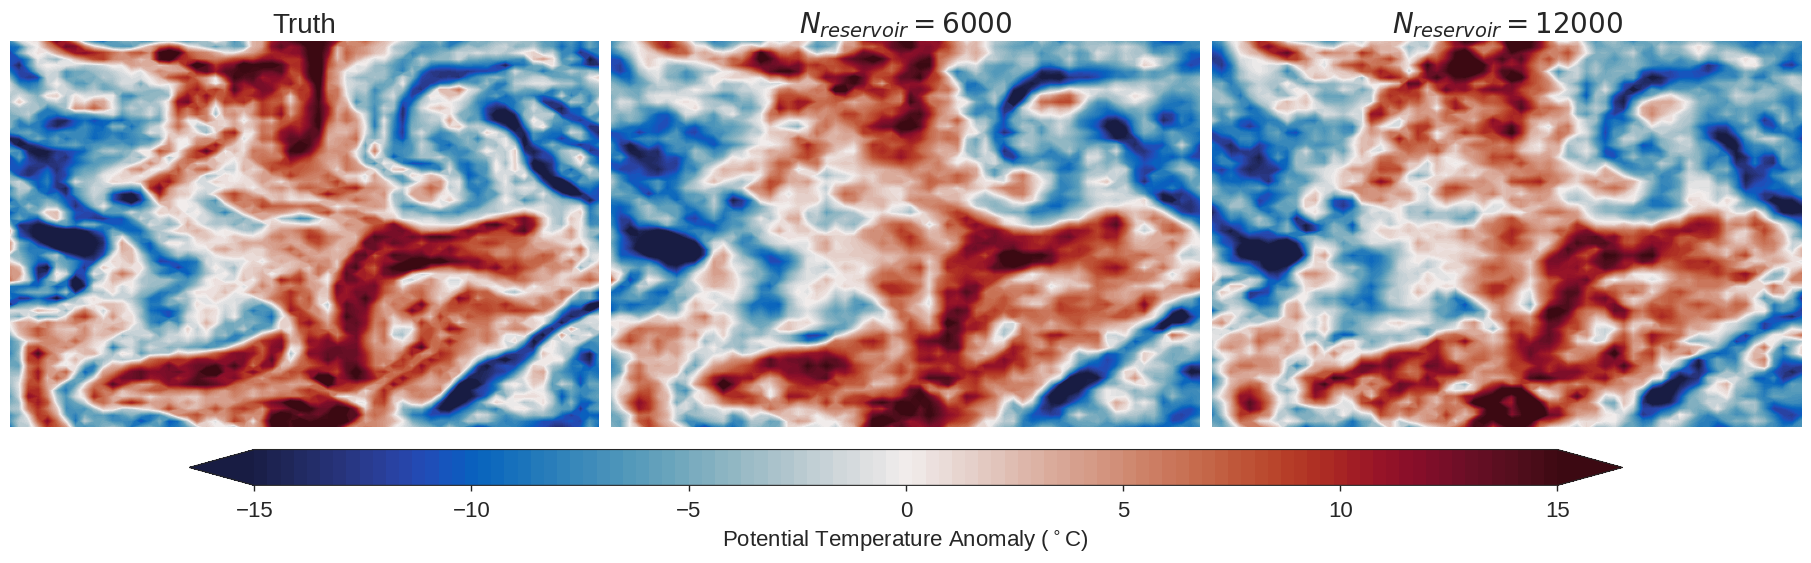

In [45]:
fig, axs = fig, axs = stp(ds.sel(gamma=0.1, n_sub=16, sample=49), col_dim="n_reservoir")
[ax.set(title=r"$N_{reservoir} = %d$" % n_reservoir) for n_reservoir, ax in zip(ds.n_reservoir.values, axs[1:])];

## Metrics

In [46]:
ds['nrmse'].load();

In [114]:
class QuickMetricsPlot(MetricsPlot):
    @property
    def color_start(self):
        return 3

In [115]:
mp = QuickMetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="n_sub",
)

### $N_{sub}=16$

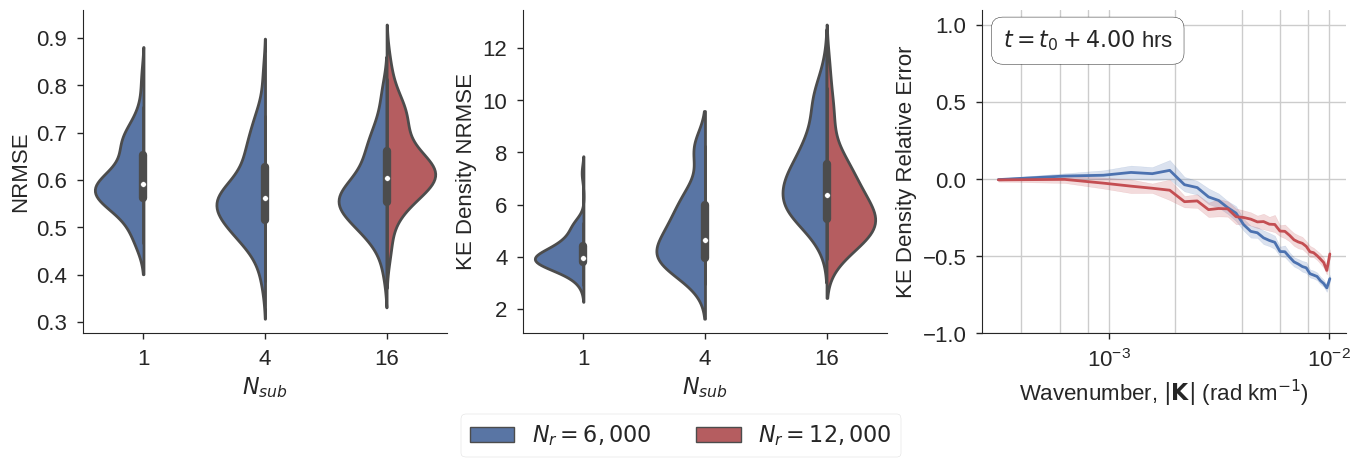

In [116]:
fig, axs = mp(ds.sel(gamma=0.1), show_time=False, hue="n_reservoir", split=True)
[ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
[ax.legend().remove() for ax in axs]
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0.1, n_sub=16),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_reservoir",
    clabel=lambda n_r : r"$N_{r} = %d$" % (n_r),
)
labels = (r"$N_r = 6,000$",) +  tuple("_nolegend_" for _ in range(4)) + (r"$N_r=12,000$",)
fig.legend(labels,
           loc="center", bbox_to_anchor=(.5, -.075), ncol=2, frameon=True)

fig.savefig(f"{fig_dir}/rc_reservoir_size.pdf", bbox_inches="tight")